# Community detection with a Bayesian stochastic block model (Peixoto, 2017)

Based on the aggregated single-layer graph with edge weights as covariates.

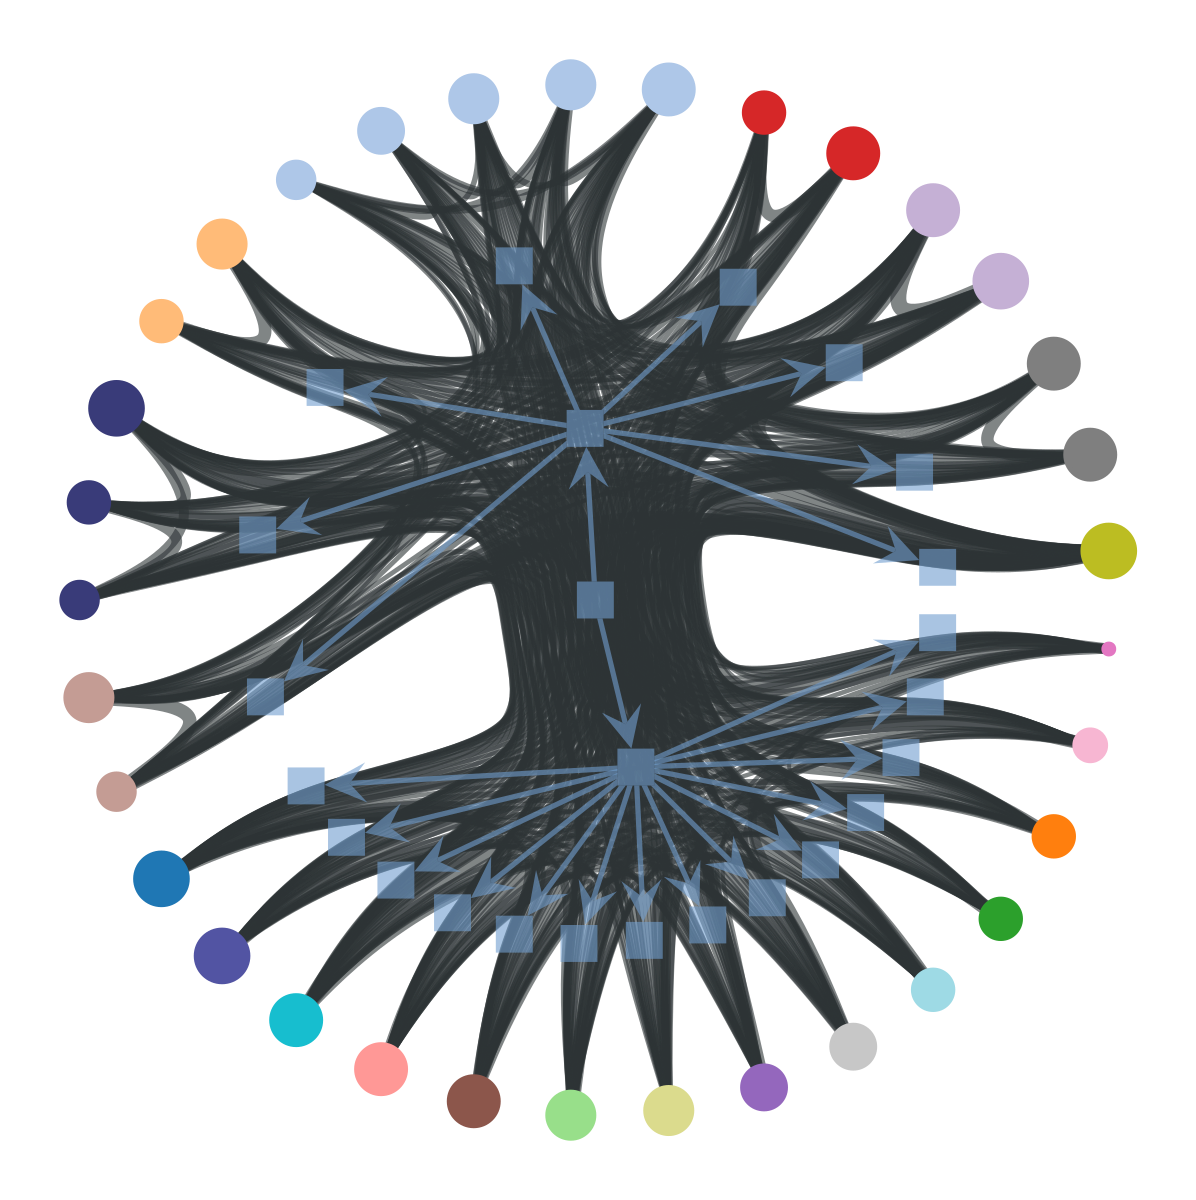

Summary of the hierarchical stochastic block model inferred from the data:
##############################################################################
l = level, N = number of nodes, B = number of blocks
l: 0, N: 33, B: 22
l: 1, N: 22, B: 2
l: 2, N: 2, B: 1
l: 3, N: 1, B: 1
    l 0 :  <BlockState object with 33 blocks (22 nonempty), degree-corrected, with 1 edge covariate, for graph <Graph object, undirected, with 33 vertices and 487 edges, 1 internal edge property, at 0x748b247fc050>, at 0x748af3dd78c0>
    l 1 :  <BlockState object with 24 blocks (2 nonempty), with 1 edge covariate, for graph <Graph object, undirected, with 33 vertices and 227 edges, 2 internal vertex properties, 1 internal edge property, at 0x748af3da6e70>, at 0x748af3e03410>
    l 2 :  <BlockState object with 5 blocks (1 nonempty), with 1 edge covariate, for graph <Graph object, undirected, with 24 vertices and 3 edges, 2 internal vertex properties, 1 internal edge property, at 0x748af3e03b00>, at 0x748af3e03500

In [15]:
import numpy as np
import igraph as ig
import matplotlib
from graph_tool.all import *
import csv
import os

n_per_layer = 33

np.set_printoptions(threshold=np.inf)

with open("outputs/01_dataPreperation/final/CAMaggregated_adj_matrix.csv", "r") as f:
    names = f.readline()

names = names.split('" "')
names[0] = names[0][1:]     # strip the first "
names[-1] = names[-1][:-2]  # strip the last \n

names = dict(enumerate(names))

adj_matrix = np.loadtxt(open("outputs/01_dataPreperation/final/CAMaggregated_adj_matrix.csv", "rb"), delimiter=" ", skiprows=1)


# remove self-loops
np.fill_diagonal(adj_matrix, 0)

G = ig.Graph.Adjacency(matrix=adj_matrix, mode="undirected")
G_edge_list = G.get_edgelist()

# ig.plot(G)
# print(G_edge_list)

G_edge_set = set(G_edge_list)
G_edge_list_new = list(G_edge_set)
G_edge_list_new = sorted(G_edge_list_new, key=lambda x: (x[0], x[1]))
# print(G_edge_list_new)

G_gt = Graph(G_edge_list_new, directed=False)
# G_gt_edge_list = list(G_gt.iter_edges())
# G_gt_edge_list = list(map(lambda x: tuple(x), G_gt_edge_list))
# G_gt_edge_list == G_edge_list
# print(G_gt)

G_gt_weights = G_gt.new_edge_property("int")

for edge in G_edge_list_new:
    G_gt_weights[edge] = G_edge_list.count(edge)

# for edge in G_edge_list_new:
#     print(edge, "has weight", G_gt_weights[edge])

G_gt.edge_properties["weight"] = G_gt_weights


def community_detection():
    np.random.seed(12345)
    graph_tool.seed_rng(12345)

    state = minimize_nested_blockmodel_dl(G_gt, state_args=dict(recs=[G_gt.ep.weight], rec_types=["discrete-binomial"]))

    # improve solution with merge-split
    for i in range(100):
        dS, nattempts, nmoves = state.multiflip_mcmc_sweep(niter=10, beta=np.inf)

    return state


def print_solution(state):
    state.draw(ecmap=(matplotlib.cm.inferno, .6),
            eorder=G_gt.ep.weight, edge_pen_width=prop_to_size(G_gt.ep.weight, 2, 8, power=1),
            edge_gradient=[])

    print("Summary of the hierarchical stochastic block model inferred from the data:")
    print("##############################################################################")
    print("l = level, N = number of nodes, B = number of blocks")
    state.print_summary()

    levels = state.get_levels()

    for i, s in enumerate(levels):
        print("    l", i, ": ", s)
        if s.get_N() == 1:
            num_levels = i
            break


    for j in range(num_levels):
        blocklist = levels[j].get_blocks()
        print("##############################################################################")
        print("LEVEL", j, "with the following blocks with at least 2 members (rest is")
        print("considered background for our purposes):\n")

        for block in set(blocklist):
            indices = [i for i, x in enumerate(blocklist) if x == block]
            if len(indices) > 1:
                print("block", block, "with:", ", ".join(map(lambda x: names[x], indices)))


def test_reproducibility():
    solutions = [[], [], []]

    for i in range(100):
        state = community_detection()

        levels = state.get_levels()

        for i, s in enumerate(levels):
            if s.get_N() == 1:
                num_levels = i
                break

        for j in range(num_levels):
            blocklist = levels[j].get_blocks()

            partitions = []

            for block in set(blocklist):
                indices = [i for i, x in enumerate(blocklist) if x == block]
                partitions += [indices]

            solutions[j] += [partitions]


    for i, level in enumerate(solutions):
        sorted_level = list(sorted(list(map(sorted, level))))
        sorted_level = set(tuple(map(lambda x: tuple(map(tuple, x)), sorted_level)))
        print("level", i, "with", len(sorted_level), "different solutions:")

        for s in sorted_level:
            print(s)

        print("############################################################")

# test_reproducibility()
# ...yields only one solution, which is fine.

state = community_detection()

print_solution(state)

# save level 0 solution to a CSV-file.
levels = state.get_levels()
blocklist = levels[0].get_blocks()
sbm_solution = list(zip(names.values(), blocklist))

with open("outputs/02_analyses_CAMs/SBM_solution.csv", mode="w", newline="", encoding="utf8") as file:
    writer = csv.writer(file)

    writer.writerow(["attribute", "community_label"])

    writer.writerows(sbm_solution)


# Community detection with Ensemble Graph Clustering (ECG) (Poulin & Théberge, 2018)

Based on the aggregated multi-edge graph.
Code from https://codeocean.com/capsule/3898939/tree/v1.

In [22]:
from ecg import *
import numpy as np
from random import seed

def community_detection_ecg():
    seed(12345)
    np.random.seed(12345)
    ec = G.community_ecg()

    ec_partitions = list(ec)
    ec_partitions = list(map(lambda x: list(map(lambda y: names[y], x)), ec_partitions))

    return ec_partitions


def test_reproducibility_ecg():
    solutions = []

    for i in range(100):
        ec_partitions = community_detection_ecg()

        ec_partitions = tuple(map(lambda x: tuple(sorted(x)), ec_partitions))

        solutions += [ec_partitions]

    print(len(set(solutions)), "different solutions")


# test_reproducibility_ecg()
# ...yields only one solution which is fine.


ec_partitions = community_detection_ecg()

for i, partition in enumerate(ec_partitions):
    print("partition", i, ":", ",".join(partition))

print(ec_partitions)


[['Akzeptanz eines neuen Materialsystems', 'wartungsintensiv', 'enthält Kunststoff', 'leicht zerstörbar', 'umweltschädlich'], ['Energie   speichernd', 'energieeffizient', 'energieautonom', 'Energie   generierend'], ['aktive Formänderung durch Umwelteinwirkung', 'reaktionsfähig', 'passive Formänderung durch Umwelteinwirkung', 'passive Verhaltensänderung durch Umwelteinwirkung', 'aktive Verhaltensänderung durch Umwelteinwirkung'], ['ökologisch', 'elektronikfrei', 'nachhaltig', 'umweltfreundlich'], ['zuverlässig', 'widerstandsfähig', 'haltbar', 'robust', 'langlebig'], ['wartungsfrei', 'selbstheilend', 'selbstreparierend'], ['Insekten ähnlich', 'bioinspiriert', 'lebensähnlich'], ['autonom', 'intelligent', 'multifunktional', 'technologisch']]
partition 0 : Akzeptanz eines neuen Materialsystems,wartungsintensiv,enthält Kunststoff,leicht zerstörbar,umweltschädlich
partition 1 : Energie   speichernd,energieeffizient,energieautonom,Energie   generierend
partition 2 : aktive Formänderung durch U

# Comparison of solutions with adjusted rand index (ARI)

In [43]:
import pandas as pd

# Read solution from Leiden + ModularityPruning
leiden_partition = pd.read_excel("outputs/02_analyses_CAMs/Leiden algorithm aggregated CAM/LeidenAlgorithm_solution.xlsx")
leiden_partition.sort_values(by=["words"], ascending=True, inplace=True, key=lambda col: col.str.lower())
# sort it alphabetically
leiden_partition = list(zip(leiden_partition["words"], leiden_partition["partition"]))

# sort the SBM solution alphabetically
sbm_solution = sorted(sbm_solution, key=lambda x: x[0].lower())

# sort the ECG solution alphabetically
ec_partitions_sorted = []
for i, partition in enumerate(ec_partitions):
    for attribute in partition:
        ec_partitions_sorted += [(attribute, i)]
ec_partitions_sorted = sorted(ec_partitions_sorted, key=lambda x: x[0].lower())

# print(leiden_partition)
# print(sbm_solution)
# print(ec_partitions_sorted)

# Rand Index (RI): Leiden vs. SBM
ri_leiden_sbm = ig.compare_communities(comm1=list(map(lambda x: x[1], leiden_partition)),
                       comm2=list(map(lambda x: x[1], sbm_solution)),
                       method="rand")
# Adjusted Rand Index (ARI): Leiden vs. SBM
ari_leiden_sbm = ig.compare_communities(comm1=list(map(lambda x: x[1], leiden_partition)),
                       comm2=list(map(lambda x: x[1], sbm_solution)),
                       method="adjusted_rand")

# Rand Index (RI): Leiden vs. SBM
ri_leiden_ec = ig.compare_communities(comm1=list(map(lambda x: x[1], leiden_partition)),
                       comm2=list(map(lambda x: x[1], ec_partitions_sorted)),
                       method="rand")
# Adjusted Rand Index (ARI): Leiden vs. ECG
ari_leiden_ec = ig.compare_communities(comm1=list(map(lambda x: x[1], leiden_partition)),
                       comm2=list(map(lambda x: x[1], ec_partitions_sorted)),
                       method="adjusted_rand")

print("Leiden vs. SBM: Rand Index =", ri_leiden_sbm)
print("Leiden vs. SBM: Adjusted Rand Index =", ari_leiden_sbm)
print("Leiden vs. ECG: Rand Index =", ri_leiden_ec)
print("Leiden vs. ECG: Adjusted Rand Index =", ari_leiden_ec)

Leiden vs. SBM: Rand Index = 0.865530303030303
Leiden vs. SBM: Adjusted Rand Index = 0.29655482999324484
Leiden vs. ECG: Rand Index = 0.9337121212121213
Leiden vs. ECG: Adjusted Rand Index = 0.7195410672008747
